In [22]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Exercise 4.7: $k$-nearest neighbors

In this exercise, you will implement $k$-nearest neighbors from scratch. This means you're allowed to use whatever `numpy` routines you would like, but you cannot use `sklearn.neighbors.KNeighborsClassifier`. 

### Part (a): Implementation

Complete the function `kNN()` below. The function takes in:
* a 2D array of training vectors `X_train`, where `X_train[i]` denotes the ith vector and `X_train[i,j]` denotes the jth entry of the ith vector;
* a collection of training labels `y_train` where `y_train[i]` is the correct label for `X_train[i]`;
* a 2D array of unlabelled vectors `X_test`
* a parameter `p` $\geq 1$ that denotes the $\ell^p$ norm to use for $k$-nearest neighbors
* the number of neighbors `k`
* a boolean `weighted`, where we compute weighted $k$-nearest neighbors if `weighted == True` and unweighted otherwise.

The function returns the predicted labels for `X_test`.

You are welcome (encouraged, in fact!) to write helper functions.

In [23]:
def distance(vectorA, vectorB, p):
    return np.sum(abs(vectorA - vectorB) ** p) ** (1/p)

In [24]:
def get_label(smallest_distances, weighted):
    labels_possible = smallest_distances[:, 1].max() + 1
    scores = np.zeros(int(labels_possible))
    
    for dist, label in smallest_distances:
        label = int(label)
        if (weighted):
            if (dist == 0):
                scores[label] += 1 # avoid dividing by zero
            else:
                scores[label] += 1/dist
        else:
            scores[label] += 1
            
    best_label = scores.argmax()
    return best_label

In [25]:
def kNN(X_train, y_train, X_test, p, k, weighted):
    # your code here...
    y_test = []

    for data_vector in X_test:
        distances = []
        for i in range(len(X_train)):
            dist = distance(data_vector, X_train[i], p)
            distances.append([dist, y_train[i]])

        distances = np.array(sorted(distances, key=lambda x: x[0])) # sort based on distances
        smallest_distances = distances[:k] # get k smallest distances + their respective labels

        label = get_label(smallest_distances, weighted)
        y_test.append(label)

    return y_test

### Part (b): Testing it on the Iris dataset

Now you will test your classifier on the Iris dataset (you can read more about it here: https://en.wikipedia.org/wiki/Iris_flower_data_set). Try out various methods for `k`, `p`, and `weighted` (note that you can approximate the $\ell^\infty$ norm by setting `p = 100` or some other large number). What works best? Plot your results and come up with some conclusions. What sort of performance do you get? You can measure the performance by simply computing what proportion of the testing data is labelled correctly; you can use `sklearn.metrics.accuracy_score` for this.

The best accuracy: 1.0, k: 5, p: 5, weight: True


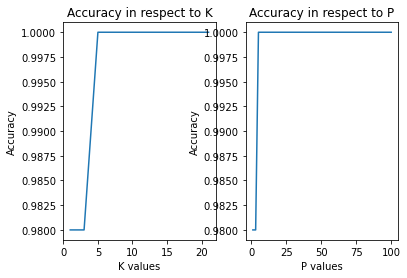

In [26]:
# load the data...
iris = datasets.load_iris()
X = iris.data
y = iris.target

# split into training and testing sets with 100 training points and 50 testing points
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 50, random_state = 42)

k_values = [1, 3, 5, 7, 9, 11, 21]
p_values = [1, 2, 3, 5, 10, 100] # you can approximate the  ℓ∞  norm by setting p = 100 or some other large number
weighted_values = [True, False]

plt.title("K-Nearest Neighbors")
plt.xlabel("X values")
plt.ylabel("Y values")

# get best parameters
best_accuracy = 0
best_k = 0
best_p = 0
best_weight = False
for k in k_values:
    for p in p_values:
        for weight in weighted_values:

            predictions = kNN(X_train, y_train, X_test, p, k, weight)
            accuracy = accuracy_score(y_test, predictions)

            if (accuracy > best_accuracy):
                best_accuracy = accuracy
                best_k = k
                best_p = p
                best_weight = weight

print(f"The best accuracy: {best_accuracy}, k: {best_k}, p: {best_p}, weight: {best_weight}")

# plot accuracy when only k changes while the other parameters are the 'best' parameters
accuracies = []
for k in k_values:
    predictions = kNN(X_train, y_train, X_test, best_p, k, best_weight)
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)

plt.subplot(1, 2, 1)
plt.title("Accuracy in respect to K")
plt.xlabel("K values")
plt.ylabel("Accuracy")
plt.plot(k_values, accuracies)

# plot accuracy when only p changes while the other parameters are the 'best' parameters
accuracies = []
for p in p_values:
    predictions = kNN(X_train, y_train, X_test, p, best_k, best_weight)
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)

plt.subplot(1, 2, 2)
plt.title("Accuracy in respect to P")
plt.xlabel("P values")
plt.ylabel("Accuracy")
plt.plot(p_values, accuracies)

plt.show()

We found that we can reach extremely high accuracy (good performance) on the IRIS dataset with K nearest neighbors even with sub-optimal parameters k and p. However, there is a slight tendency for the accuracy to be perfect (100% accuracy) with higher values of K, which makes sense because each test point would compare to more points, thus get a better sense of its

# Exercise 5.4: $k$-means clustering

The MNIST databasste is a very famous database consisting of images of handwritten digits, used as a standard benchmark for a variety of image processing tasks. The database consists of 1797 $8\times 8$ grayscale images of digits, each flattened into a vector of length 64. Let's load the data and visualize some of the data.

In [27]:
X, y = datasets.load_digits(return_X_y = True)
X = X/np.max(X) # do some normalizing
X.shape

(1797, 64)

In [28]:
def visualize_digit(X, y, k):
    '''
    Plot a digit from the MNIST database and print its label.
    INPUTS:
        X: digits in the MNIST database
        y: labels in the MNIST database
        k: the index of the datapoint you wish to visualize
    '''
    if type(k) != int:
        print("k must be supplied as integer!")
        return -1
    
    if k < 0 or k >= X.shape[0]:
        print("index k is out of bounds, must be between 0 and 1796!")
        return -1
    
    print(f"Image label: {y[k]}")
    plt.imshow(np.reshape(X[k], (8, 8)), cmap='gray')

Image label: 1


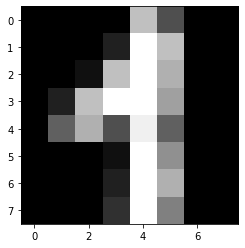

In [29]:
# try some different values of k
k = 42 
visualize_digit(X, y, k)

## Part (a): Implement $k$-means

Implement $k$-means from scratch (you are permitted to use any numpy routines you'd like) by filling out the function `kmeans()` below. You are welcome to shuffle the code around as you please; this is only a starting point. You are also welcome and encouraged to write helper functions.

In [37]:
import random
from random import randrange

def kmeans(X, k):
    '''
    implement k-means
    INPUT:
        X: numpy array of shape (N,d), where n is number of data
            points and d is dimension (d = 64 in our case)
        k: desired number of clusters
    OUTPUT:
        m: numpy array of shape (k,) of cluster centers
        gamma: numpy array of shape (N,), where each entry is 
            an integer from 0 to k-1 denoting cluster membership
        distortions: list of distortions at each iteration
    '''
    N, d = X.shape

    distortions = [] # keep track of distortion at each step

    # create m and gamma arrays
    m = np.zeros(shape = (k, d)) # added a dimension d because centroids have d dimensions
    gamma = np.zeros(shape = N)

    ''' debug '''
    label = np.zeros(shape = k)
    ''' debug '''
    
    for i in range(k):
        index = randrange(N)
        m[i] = X[index]
        
        label[i] = y[index]
        
    ''' debug '''
    plt.figure(figsize=(15, 6))
    for i in range(len(m)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.reshape(m[i], (8, 8)), cmap='gray')
        plt.title(f"Label - {int(label[i])}")
        plt.axis("off")
    plt.show()
    ''' debug '''
    
    loop = 0;
    iteration = 0
    while (len(distortions) < 2 or distortions[-2] != distortions[-1]): 
        # your code here..., while distortion isn't converged
        for i in range(N):
            data_point = X[i]
            smallest_distance = 1000000000
            
            for j in range(len(m)):
                dist = distance(m[j], data_point, 2)
                
                if (dist < smallest_distance):
                    smallest_distance = dist
                    cluster_assignment = j
                    
            gamma[i] = int(cluster_assignment)
        
        m = np.zeros((k, d)) # reset m
        counter = np.zeros(k)
        
        for i in range(N):
            cluster_assignment = int(gamma[i])
            data_point = X[i]
            m[cluster_assignment] += data_point # ??
            ''' debug '''
            if loop < 10 and cluster_assignment == 0:
                plt.figure(figsize=(15, 6))
                plt.imshow(np.reshape(X[i], (8, 8)), cmap='gray')
                plt.imshow(np.reshape(m[cluster_assignment], (8,8)), cmap='gray')
                plt.axis("off")
                plt.show()
                loop += 1
            ''' debug '''
            counter[cluster_assignment] += 1
            
        for i in range(k):
            if (counter[i] == 0): 
                continue
            m[i] /= counter[i] # ??
            
        distortion = 0
        for i in range(N):
            data_point = X[i]
            cluster_assignment = int(gamma[i])
            distortion += distance(data_point, m[cluster_assignment], 2) ** 2 # take to the power of 2 to counteract the square root
        distortions.append(distortion)
        
        iteration += 1
    
    print(f"TOTAL ITERATIONS RUN: {iteration}")
    
    return m, gamma, distortions

## Part (b); Run on MNIST

We will now try running `kmeans()` on the MNIST dataset. Since the MNIST dataset consists of 10 different possible digits, it makes sense to try to classify them into $k = 10$ different clusters. If we think about the center of each cluster as a "representative" of the other points in that cluster, we can try plotting the resultant cluster centers and seeing if they look like numbers.

Run `kmeans()` on the MNIST data and plot the cluster centers. Do they look like digits? Remember that your centers will be arrays of shape `(64,)`. You will have to reshape them into arrays of shape `(8,8)` using `np.reshape()`, then plot them using `plt.imshow()` (see the last line of the function `visualize_digit` written above).

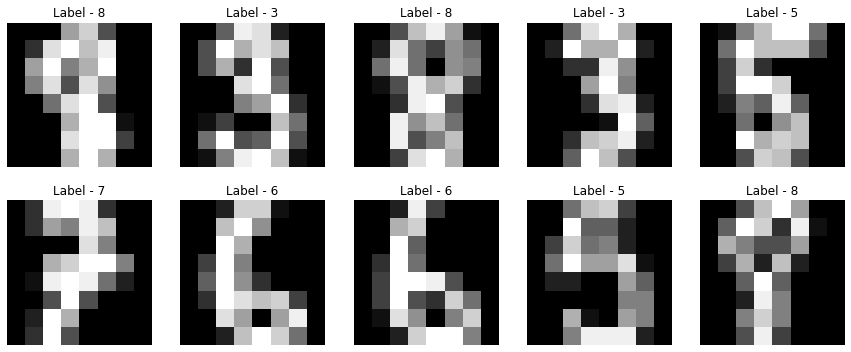

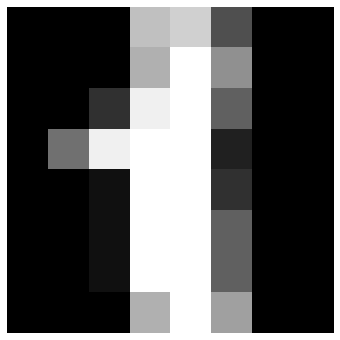

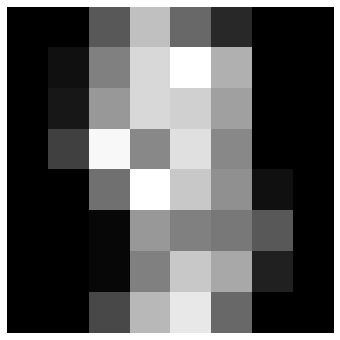

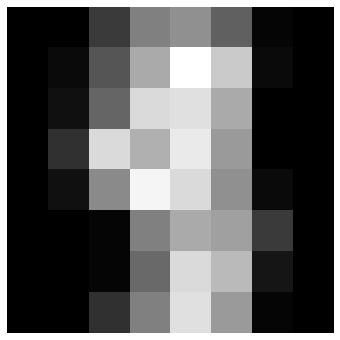

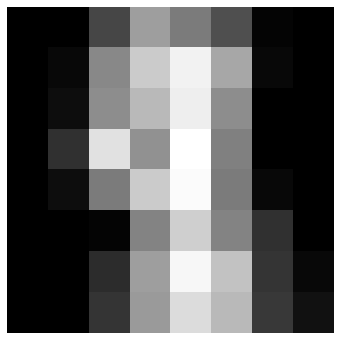

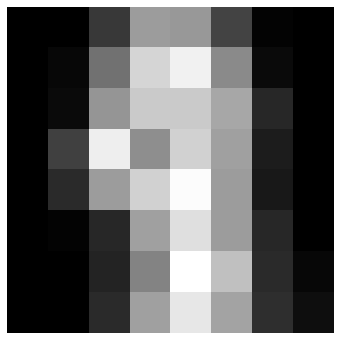

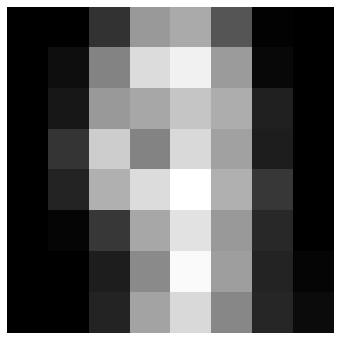

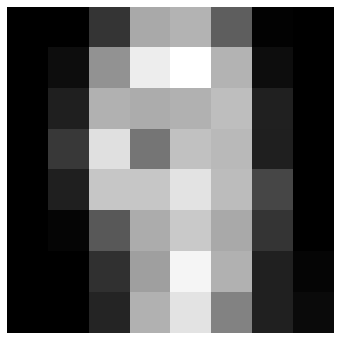

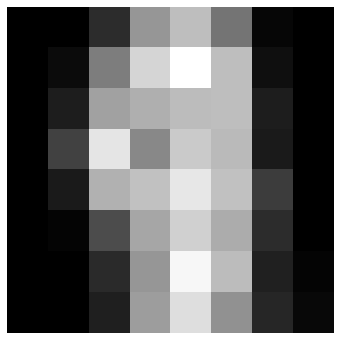

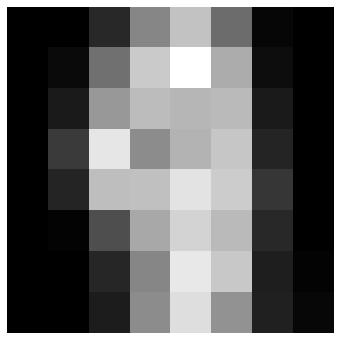

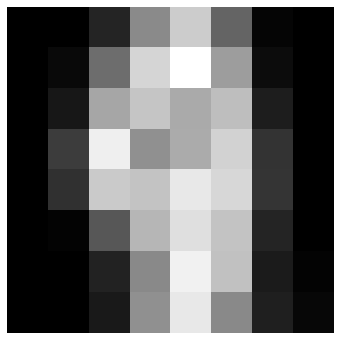

TOTAL ITERATIONS RUN: 16


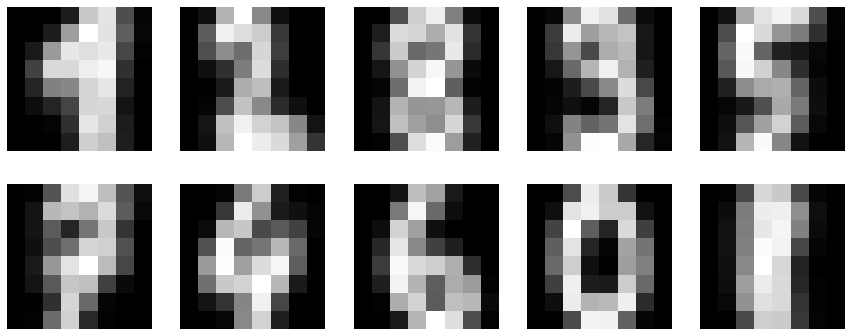

In [38]:
# your code here...
m, gamma, distortions = kmeans(X, 10)

plt.figure(figsize=(15, 6))
for i in range(len(m)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.reshape(m[i], (8, 8)), cmap='gray')
    plt.axis("off")
plt.show()